# 1. Esplorazione iniziale dei dati, e pulizia

In [1]:
import pandas as pd
import numpy as np
import ast
from collections import Counter
import ast 

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Ignora tutti i warning
warnings.filterwarnings('ignore')

- Caricare il dataset e dare un’occhiata generale: dimensioni, tipi di variabili, presenza di valori mancanti.

In [2]:
csv_file_path = 'ptbxl_database.csv'
db = pd.read_csv(csv_file_path)
db.head()

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr


Nella colonna SEX i valori sono 0=male, 1=female

In [3]:
conteggio = db['sex'].value_counts().sort_index()
print(conteggio)

sex
0    11354
1    10445
Name: count, dtype: int64


### Pulizia

- Rimuovere record doppi (pazienti doppi).

In [4]:
db_unique=db.drop_duplicates(subset='patient_id')
n_duplic = len(db)-len(db_unique)

print("Pazienti iniziali: ", len(db))
print("Pazienti unici: ", len(db_unique))
print(f"(Duplicati tolti: {n_duplic})")


Pazienti iniziali:  21799
Pazienti unici:  18869
(Duplicati tolti: 2930)


- Verificare eventuali outlier o valori incoerenti in età (età = 300 anni) -> età simbolica 100 

The date of birth only as age at the time of the ECG recording, where ages of more than 89 years appear in the range of 300 years in compliance with HIPAA standards.

In [5]:
age_counts = db_unique.groupby('age').size().reset_index(name='count')
print(age_counts)


      age  count
0     2.0      1
1     3.0      2
2     4.0      2
3     5.0      2
4     6.0      1
..    ...    ...
84   86.0    146
85   87.0    200
86   88.0    119
87   89.0     81
88  300.0    257

[89 rows x 2 columns]


In [6]:
db_unique.loc[db_unique['age'] > 90, 'age'] = 100
age_counts = db_unique.groupby('age').size().reset_index(name='count')
print(age_counts)

      age  count
0     2.0      1
1     3.0      2
2     4.0      2
3     5.0      2
4     6.0      1
..    ...    ...
84   86.0    146
85   87.0    200
86   88.0    119
87   89.0     81
88  100.0    257

[89 rows x 2 columns]


- Trasformare variabili categoriali (diagnosi) in formato adatto → aggiungere una colonna per ogni SCP code, e mettere come valore la likelihood associata.

In [7]:
import pandas as pd
import ast
import numpy as np
from collections import defaultdict

colonna_da_analizzare = 'scp_codes'
df = db_unique 

# Il codice qui sotto assume che 'df' (che è 'db_unique') e 'colonna_da_analizzare' siano stati definiti

# --- 2. Analisi Singole Diagnosi con Valore > 0 ---
if df is not None:
    if colonna_da_analizzare in df.columns:
        
        print(f"\n--- Inizio analisi della colonna '{colonna_da_analizzare}' (Valore > 0) ---")

        # Funzione modificata per contare le patologie con valore > 0
        def conta_diagnosi_maggiori_di_zero(stringa_dict, conteggi):
            """
            Parsa la stringa del dizionario e aggiorna il conteggio delle patologie
            se il loro valore è maggiore di 0.
            """
            try:
                # Usa ast.literal_eval per convertire la stringa in un dizionario
                mio_dict = ast.literal_eval(stringa_dict)
                if isinstance(mio_dict, dict):
                    # Itera su tutte le coppie chiave-valore nel dizionario
                    for chiave, valore in mio_dict.items():
                        # Verifica se il valore è numerico e > 0
                        if isinstance(valore, (int, float)) and valore > 0:
                            # Incrementa il conteggio per quella specifica patologia (chiave)
                            conteggi[chiave] += 1
            except (ValueError, SyntaxError, TypeError):
                # Gestisce i casi in cui la stringa non è un dizionario valido
                pass
            # Questa funzione non ritorna nulla, ma modifica il dizionario 'conteggi'
            return None 

        # Inizializza un dizionario per memorizzare i conteggi (defaultdict per semplificare l'incremento)
        conteggi_patologie = defaultdict(int)

        # Applica la funzione a ogni riga, passando il dizionario dei conteggi
        # Con 'apply', è più efficiente iterare per modificare l'oggetto esterno, dato che
        # la logica è più complessa del semplice estrarre una lista di chiavi.
        df[colonna_da_analizzare].apply(lambda x: conta_diagnosi_maggiori_di_zero(x, conteggi_patologie))

        # Conversione del defaultdict in una Serie pandas per la formattazione e la stampa
        conteggio_diagnosi_serie = pd.Series(conteggi_patologie).sort_values(ascending=False)
        
        print("\n====================================")
        print("--- CONTEGGIO PAZIENTI PER DIAGNOSI (Valore > 0) ---")
        
        # Stampa il numero totale di TIPI di diagnosi trovate
        num_tipi_diagnosi = len(conteggio_diagnosi_serie)
        print(f"Trovate {num_tipi_diagnosi} tipologie di diagnosi uniche con almeno un paziente con Valore > 0.")
        
        print("\nElenco numerato delle diagnosi (con conteggio pazienti):")
        
        # Trasforma la Serie in un DataFrame per stamparla meglio
        conteggio_df = conteggio_diagnosi_serie.reset_index()
        
        # Rinomina le colonne per chiarezza
        conteggio_df.columns = ['diagnosi', 'conteggio_pazienti_valore_maggiore_zero']
        
        # Imposta l'indice per partire da 1 (invece che da 0)
        conteggio_df.index = conteggio_df.index + 1        
        
        # Imposta pandas per mostrare tutte le righe (se sono < 100)
        pd.set_option('display.max_rows', 100)
        
        # Stampa il DataFrame numerato
        print(conteggio_df)
        
        # Resetta l'opzione di visualizzazione
        pd.reset_option('display.max_rows')
        print("====================================")

    else:
        print(f"ERRORE: La colonna '{colonna_da_analizzare}' non esiste nel file.")


--- Inizio analisi della colonna 'scp_codes' (Valore > 0) ---

--- CONTEGGIO PAZIENTI PER DIAGNOSI (Valore > 0) ---
Trovate 52 tipologie di diagnosi uniche con almeno un paziente con Valore > 0.

Elenco numerato delle diagnosi (con conteggio pazienti):
   diagnosi  conteggio_pazienti_valore_maggiore_zero
1      NORM                                     8703
2       IMI                                     2191
3      ASMI                                     1900
4       LVH                                     1799
5       NDT                                     1561
6      LAFB                                     1396
7      ISC_                                     1022
8     IRBBB                                      993
9       PVC                                      832
10     IVCD                                      661
11     1AVB                                      616
12    ISCAL                                      516
13     NST_                                      455
14  

In [8]:
output_filename = 'db_scp_expanded.csv'

if df is not None:
    
    # --- 2. Definisci Colonne Base e Colonna Diagnosi ---
    
    colonne_base = ['patient_id', 'sex', 'age', 'height', 'weight', 'scp_codes']
    
    colonna_diagnosi = 'scp_codes'

    # Verifica che le colonne esistano
    colonne_da_mantenere = [col for col in colonne_base if col in df.columns]
    if colonna_diagnosi not in df.columns:
        print(f"ERRORE: La colonna '{colonna_diagnosi}' non è stata trovata.")
        df = None # Blocca l'esecuzione
    else:
        print(f"Colonne base da includere: {colonne_da_mantenere}")

if df is not None:
    
    # --- 3. Converti la stringa 'scp_codes' in veri dizionari ---
    print(f"\n--- Inizio parsing della colonna '{colonna_diagnosi}' ---")

    def parse_scp(codice_str):
        try:
            # ast.literal_eval è il modo sicuro per convertire una stringa
            return ast.literal_eval(codice_str)
        except (ValueError, SyntaxError, TypeError):
            # Se la cella è vuota (NaN) o malformata, ritorna un dizionario vuoto
            return {} 

    # Applica la funzione a ogni riga, creando una Serie di dizionari
    serie_di_dizionari = df[colonna_diagnosi].apply(parse_scp)
    
    print("Parsing completato.")

    # --- 4. "Esplodi" i Dizionari in Colonne (Il passaggio chiave) ---
    print("Creazione delle colonne per le diagnosi...")
    
    diagnosi_df = pd.DataFrame(serie_di_dizionari.tolist())

    # --- 5. Pulizia del nuovo DataFrame di diagnosi ---
    diagnosi_df = diagnosi_df.fillna(0.0)
    
    num_diagnosi_create = len(diagnosi_df.columns)
    print(f"Create con successo {num_diagnosi_create} colonne di diagnosi.")
    
    # Nota: questo è solo un avviso, non un errore.
    if num_diagnosi_create != 71:
        print(f"ATTENZIONE: Il conteggio (71) era leggermente diverso. Create {num_diagnosi_create} colonne.")

    # --- 6. Combinazione dei DataFrame ---
    print("Combinazione dei dati anagrafici e delle diagnosi...")
    
    # df_base ora includerà 'ecg_id' grazie alla modifica nello Step 2
    df_base = df[colonne_da_mantenere]

    df_base = df_base.reset_index(drop=True)
    diagnosi_df = diagnosi_df.reset_index(drop=True)

    # Concatena i due DataFrame fianco a fianco (axis=1)
    df_carlo = pd.concat([df_base, diagnosi_df], axis=1)

    # --- 7. Salvataggio ---
    try:
        df_carlo.to_csv(output_filename, index=False, float_format='%.1f')
        print(f"\n====================================")
        print(f"--- SALVATAGGIO COMPLETATO ---")
        print(f"Nuovo database salvato come: {output_filename}")
        print("\n--- Prime 5 righe del nuovo file ---")
        print(df_carlo.head())
        print("====================================")
    except Exception as e:
        print(f"\n--- ERRORE NEL SALVATAGGIO ---")
        print(f"Si è verificato un errore: {e}")

Colonne base da includere: ['patient_id', 'sex', 'age', 'height', 'weight', 'scp_codes']

--- Inizio parsing della colonna 'scp_codes' ---
Parsing completato.
Creazione delle colonne per le diagnosi...
Create con successo 71 colonne di diagnosi.
Combinazione dei dati anagrafici e delle diagnosi...

--- SALVATAGGIO COMPLETATO ---
Nuovo database salvato come: db_scp_expanded.csv

--- Prime 5 righe del nuovo file ---
   patient_id  sex   age  height  weight  \
0     15709.0    1  56.0     NaN    63.0   
1     13243.0    0  19.0     NaN    70.0   
2     20372.0    1  37.0     NaN    69.0   
3     17014.0    0  24.0     NaN    82.0   
4     17448.0    1  19.0     NaN    70.0   

                                  scp_codes   NORM  LVOLT   SR  SBRAD  ...  \
0  {'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}  100.0    0.0  0.0    0.0  ...   
1              {'NORM': 80.0, 'SBRAD': 0.0}   80.0    0.0  0.0    0.0  ...   
2                {'NORM': 100.0, 'SR': 0.0}  100.0    0.0  0.0    0.0  ...   
3    

<hr>

## Visualizzazione

### Sesso

Grafico a torta

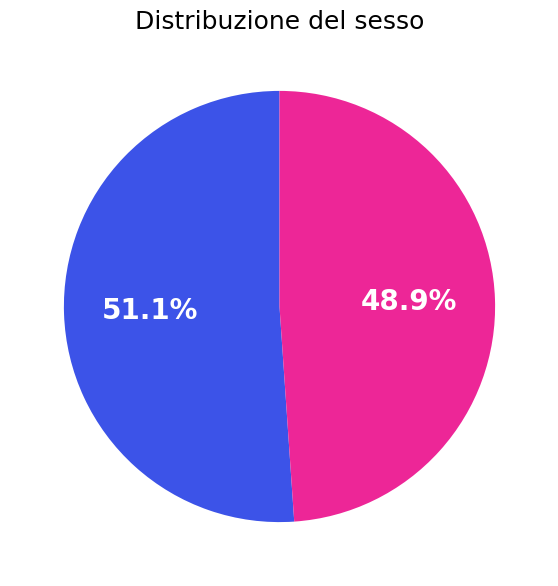

In [9]:
df = pd.read_csv('db_scp_expanded.csv')
# Conta il numero di maschi e femmine
counts = df['sex'].value_counts().sort_index()  # Ordina per 0 e 1
male_count = counts.get(0, 0)
female_count = counts.get(1, 0)

# Definisci etichette e colori
labels = ['Male', 'Female']
colors = ['#3c53e8', '#ed2697']

# Crea il grafico a torta
plt.figure(figsize=(7,7))
wedges, texts, autotexts = plt.pie(
    counts, 
    #labels=labels, 
    colors=colors, 
    autopct='%1.1f%%', 
    startangle=90, 
    textprops={'fontsize': 14}
)
plt.title('Distribuzione del sesso', fontsize=18)

# Modifica lo stile delle percentuali
for autotext in autotexts:
    autotext.set_color('white')      # colore bianco
    autotext.set_fontweight('bold')  # grassetto
    autotext.set_fontsize(20)        # font più grande

plt.show()

### Età

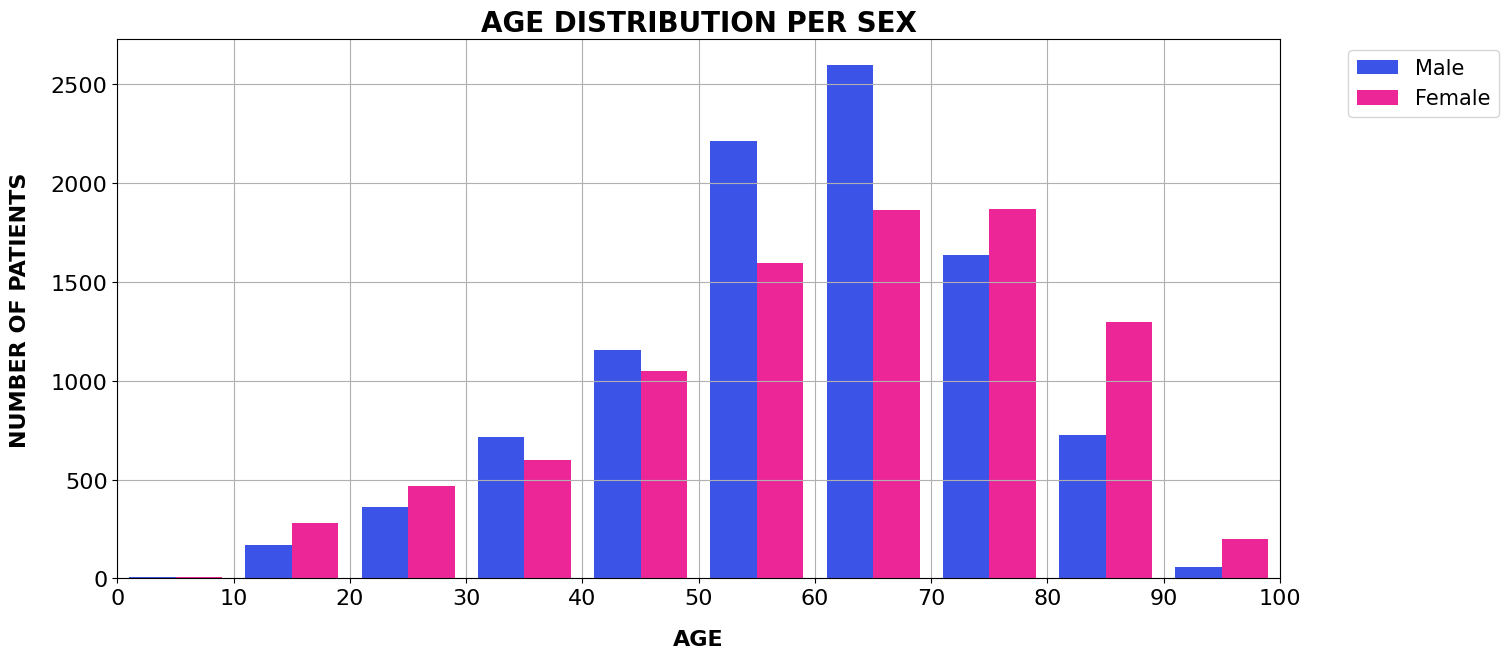

In [10]:
r = np.arange(0, 105, 10)

fig, ax = plt.subplots(figsize=(15,7))

# Istogramma con colori personalizzati
colors = ['#3c53e8', '#ed2697']  # maschi e femmine
ax.hist(
    [df['age'].loc[df['sex']==0], df['age'].loc[df['sex']==1]],
    bins=r,
    density=False,
    histtype='bar',
    label=["Male", "Female"],
    color=colors
)

# Titolo
ax.set_title('AGE DISTRIBUTION PER SEX', fontsize=20, fontweight='bold')

# Griglia, assi e limiti
# Griglia, assi e limiti
plt.grid(True)
plt.xticks(r, fontsize=16)  # ingrandisce i numeri dell'asse x
plt.yticks(fontsize=16)     # ingrandisce i numeri dell'asse y
plt.xlim(min(r), max(r))
plt.xlabel('AGE', fontsize=16, fontweight='bold', labelpad=15)   # aumenta distanza dalla x
plt.ylabel('NUMBER OF PATIENTS', fontsize=16, fontweight='bold', labelpad=15)  # aumenta distanza dalla y


# Annotazioni altezza barre 
#for rect in ax.patches: 
# height = rect.get_height() 
# ax.annotate(f'{int(height)}', 
# xy=(rect.get_x() + rect.get_width()/2, height), 
# xytext=(0, 5),
# textcoords='offset points', 
# ha='center', 
# va='bottom')

# Legenda
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', prop={'size': 15})

plt.show()


## Plot of sex over age intervals that don't have weight\height

File 'ptbxl_database.csv' caricato con successo.
Dati pronti per il plot (fasce di 20 anni).


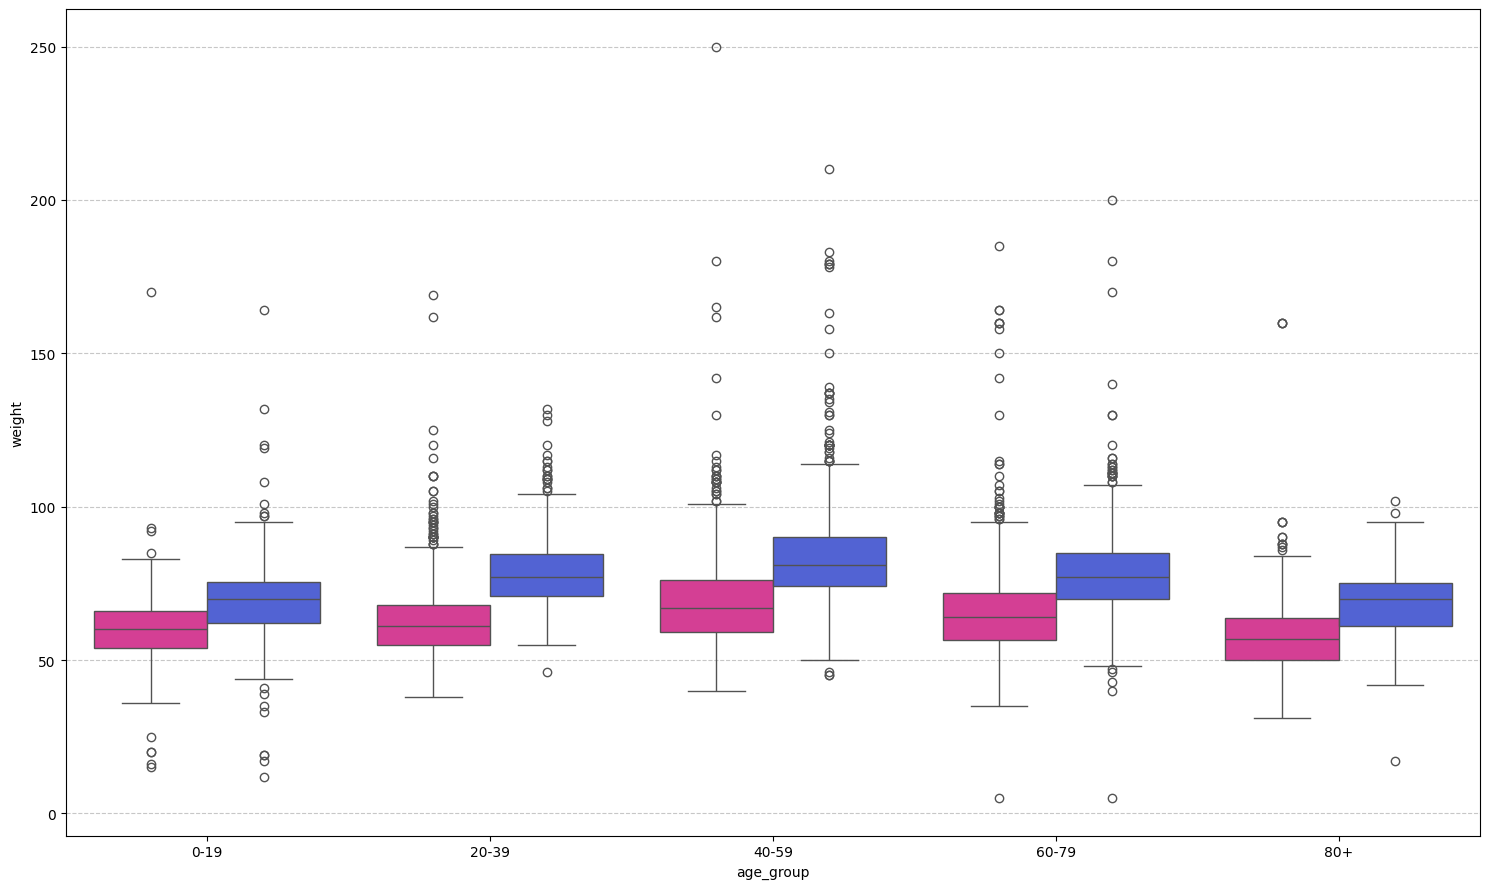

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Caricamento Dati ---
file_name = 'ptbxl_database.csv'
try:
    df = pd.read_csv(file_name)
    print(f"File '{file_name}' caricato con successo.")
except FileNotFoundError:
    print(f"ERRORE: File '{file_name}' non trovato.")
    exit()
except Exception as e:
    print(f"Errore nel caricamento: {e}")
    exit()

# --- 2. Preparazione Dati ---

# Assicurati che le colonne necessarie esistano
required_cols = ['age', 'sex', 'weight']
if not all(col in df.columns for col in required_cols):
    print(f"ERRORE: Il file deve contenere le colonne: {required_cols}")
    exit()

# Filtra i dati: rimuovi righe dove mancano i valori che ci servono
df_plot = df.dropna(subset=required_cols).copy()

# Definiamo i limiti delle fasce d'età ogni 20 anni
# (0-19, 20-39, 40-59, 60-79, 80+)
bins = [0, 20, 40, 60, 80, np.inf]
# Definiamo le etichette per quelle fasce
labels = ['0-19', '20-39', '40-59', '60-79', '80+']

df_plot['age_group'] = pd.cut(df_plot['age'], bins=bins, labels=labels, right=False)

# --- 2b. Preparazione Sesso e Colori ---

# Mappiamo i valori numerici del sesso (0, 1) a etichette chiare
# Assumiamo 0 = Uomo, 1 = Donna (modifica se necessario)
df_plot['sex_label'] = df_plot['sex'].map({0: 'Uomo', 1: 'Donna'})

# Recuperiamo la tua palette di colori memorizzata
color_palette = {
    'Uomo': '#3c53e8',
    'Donna': '#ed2697'
}

# Filtriamo ulteriormente il dataframe per evitare errori nel plot
df_plot = df_plot[df_plot['sex_label'].isin(['Uomo', 'Donna'])]
# Rimuoviamo eventuali gruppi di età non trovati
df_plot = df_plot.dropna(subset=['age_group'])

print("Dati pronti per il plot (fasce di 20 anni).")

# --- 3. Creazione Grafico ---
plt.figure(figsize=(15, 9))

ax = sns.boxplot(
    data=df_plot,
    x='age_group',  # <-- Usiamo le fasce d'età
    y='weight',     # <-- Peso sull'asse Y
    hue='sex_label',# <-- Sesso per il colore
    palette=color_palette # <-- Tua palette personalizzata
)

ax.get_legend().remove()



plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# --- 5. Mostra Grafico ---
plt.show()

File 'ptbxl_database.csv' caricato con successo.
Dati pronti per il plot (fasce di 20 anni).


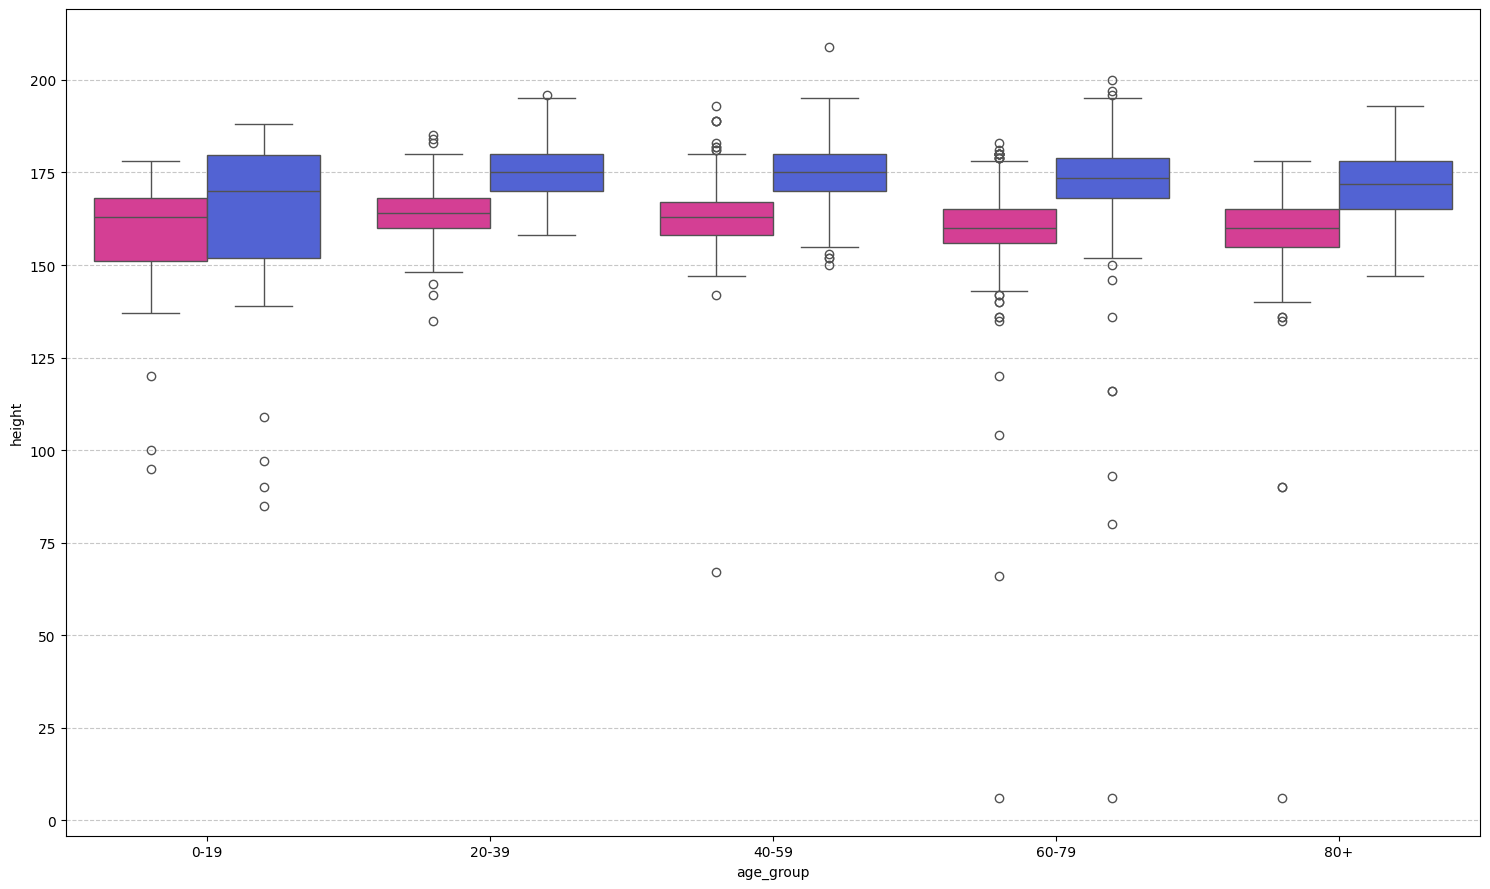

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Caricamento Dati ---
file_name = 'ptbxl_database.csv'
try:
    df = pd.read_csv(file_name)
    print(f"File '{file_name}' caricato con successo.")
except FileNotFoundError:
    print(f"ERRORE: File '{file_name}' non trovato.")
    exit()
except Exception as e:
    print(f"Errore nel caricamento: {e}")
    exit()

# --- 2. Preparazione Dati ---

# Assicurati che le colonne necessarie esistano
required_cols = ['age', 'sex', 'height']
if not all(col in df.columns for col in required_cols):
    print(f"ERRORE: Il file deve contenere le colonne: {required_cols}")
    exit()

# Filtra i dati: rimuovi righe dove mancano i valori che ci servono
df_plot = df.dropna(subset=required_cols).copy()

# --- 2a. Raggruppamento Età (Binning) ---

# Definiamo i limiti delle fasce d'età ogni 20 anni
# (0-19, 20-39, 40-59, 60-79, 80+)
bins = [0, 20, 40, 60, 80, np.inf]
# Definiamo le etichette per quelle fasce
labels = ['0-19', '20-39', '40-59', '60-79', '80+']

df_plot['age_group'] = pd.cut(df_plot['age'], bins=bins, labels=labels, right=False)

# --- 2b. Preparazione Sesso e Colori ---

# Mappiamo i valori numerici del sesso (0, 1) a etichette chiare
# Assumiamo 0 = Uomo, 1 = Donna (modifica se necessario)
df_plot['sex_label'] = df_plot['sex'].map({0: 'Uomo', 1: 'Donna'})

# Recuperiamo la tua palette di colori memorizzata
color_palette = {
    'Uomo': '#3c53e8',
    'Donna': '#ed2697'
}

# Filtriamo ulteriormente il dataframe per evitare errori nel plot
df_plot = df_plot[df_plot['sex_label'].isin(['Uomo', 'Donna'])]
# Rimuoviamo eventuali gruppi di età non trovati
df_plot = df_plot.dropna(subset=['age_group'])

print("Dati pronti per il plot (fasce di 20 anni).")

# --- 3. Creazione Grafico ---
plt.figure(figsize=(15, 9))

ax = sns.boxplot(
    data=df_plot,
    x='age_group',  # <-- Usiamo le fasce d'età
    y='height',     # <-- Peso sull'asse Y
    hue='sex_label',# <-- Sesso per il colore
    palette=color_palette, # <-- Tua palette personalizzata
)

ax.get_legend().remove()



plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# --- 5. Mostra Grafico ---
plt.show()

### Diagnosi

Torta: NORM vs ALTRO, e poi spacchettiamo altro per vedere cosa c'è dentro

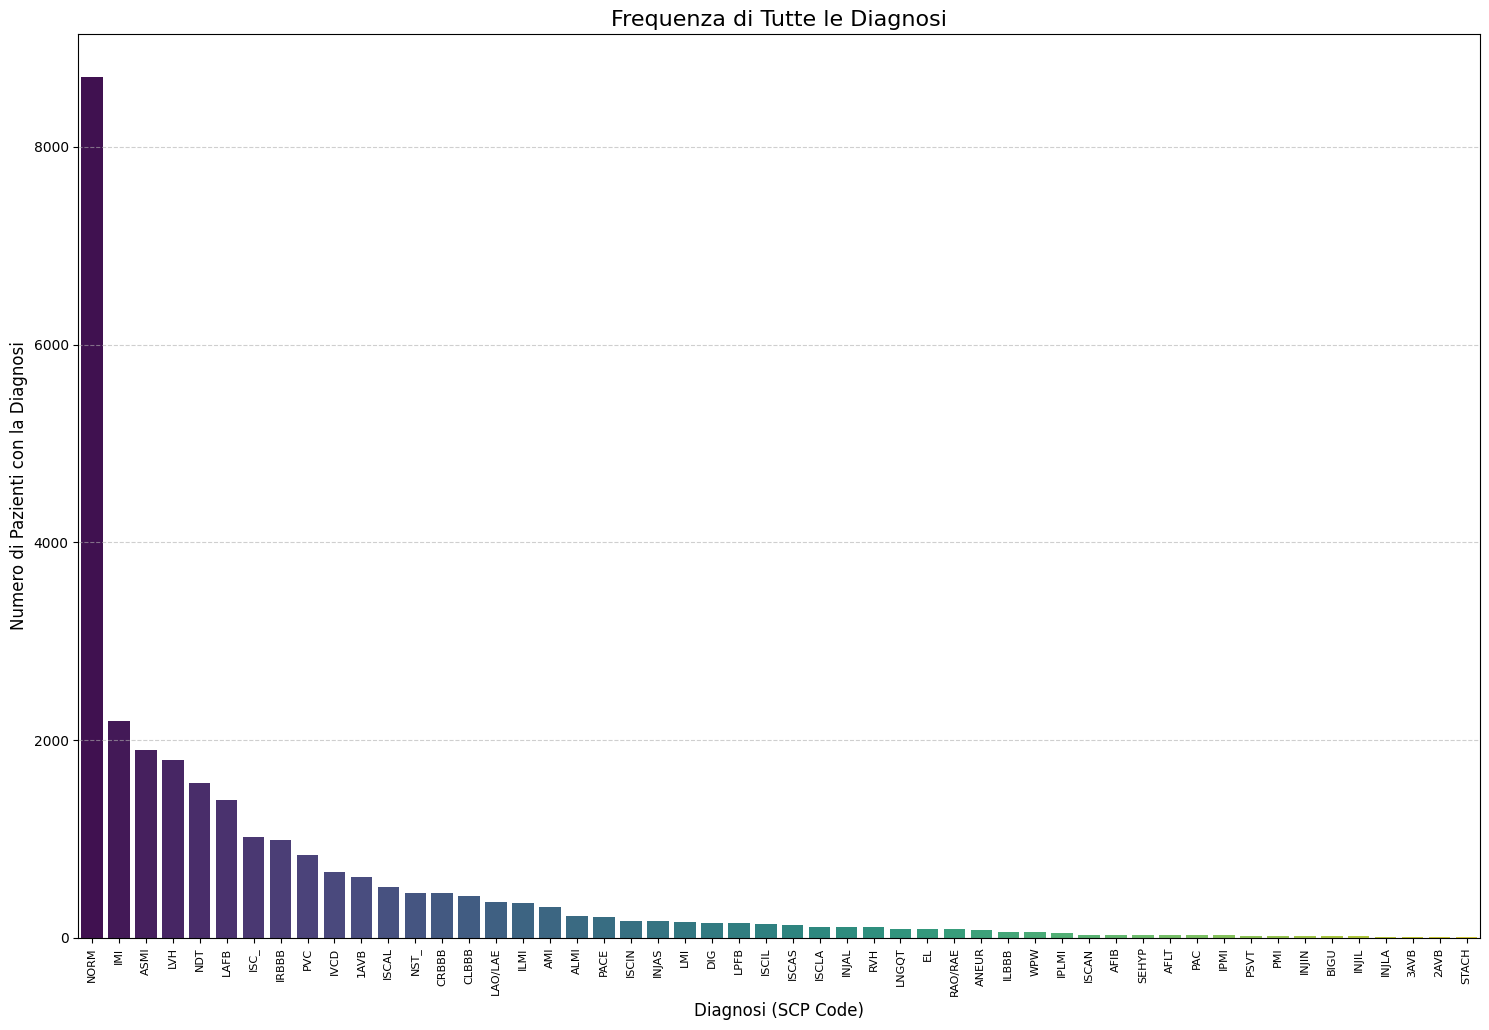

In [11]:
import pandas as pd
from collections import Counter
import ast
import matplotlib.pyplot as plt
import seaborn as sns

# Supponiamo che il tuo DataFrame 'df' sia già caricato e pulito.
# --- PASSO 0: Conversione della colonna (Necessaria se i dizionari sono stringhe) ---
try:
    # Riconverte la stringa in un dizionario Python
    df['scp_codes'] = df['scp_codes'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
except Exception as e:
    print(f"Errore nella conversione del dizionario: {e}")
    # Gestisci l'errore

# --- PASSO 1: Estrarre e contare le diagnosi (> 0%) ---

tutte_le_diagnosi = (
    df['scp_codes']
    # Filtra e appiattisci le diagnosi
    .apply(lambda d: [k for k, v in d.items() if v > 0] if isinstance(d, dict) else [])
    .explode()  
    .dropna()  
    .tolist()
)

conteggio_diagnosi = Counter(tutte_le_diagnosi)

# Converti in DataFrame e ordina
df_conteggi = pd.Series(conteggio_diagnosi).reset_index()
df_conteggi.columns = ['Diagnosi', 'Conteggio']
df_conteggi = df_conteggi.sort_values(by='Conteggio', ascending=False)


# --- PASSO 2: Generazione del Grafico a Barre (Scala Verticale Ricalibrata) ---

# NUOVA SCALA: Riduci il fattore a 0.2 (o 0.15 per una compressione estrema)
num_diagnosi = len(df_conteggi)
fig_height = max(6, num_diagnosi * 0.2) # Fattore 0.2 per ridurre l'altezza

plt.figure(figsize=(15, fig_height)) # Larghezza fissa (15), altezza dinamica ma compatta

sns.barplot(
    x='Diagnosi', 
    y='Conteggio', 
    data=df_conteggi,
    palette='viridis' 
)

plt.title('Frequenza di Tutte le Diagnosi', fontsize=16)
plt.xlabel('Diagnosi (SCP Code)', fontsize=12)
plt.ylabel('Numero di Pazienti con la Diagnosi', fontsize=12)

# Ruota le etichette X e aumenta leggermente la dimensione della font se necessario
plt.xticks(rotation=90, ha='center', fontsize=8) 
plt.yticks(fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout() 
plt.show()

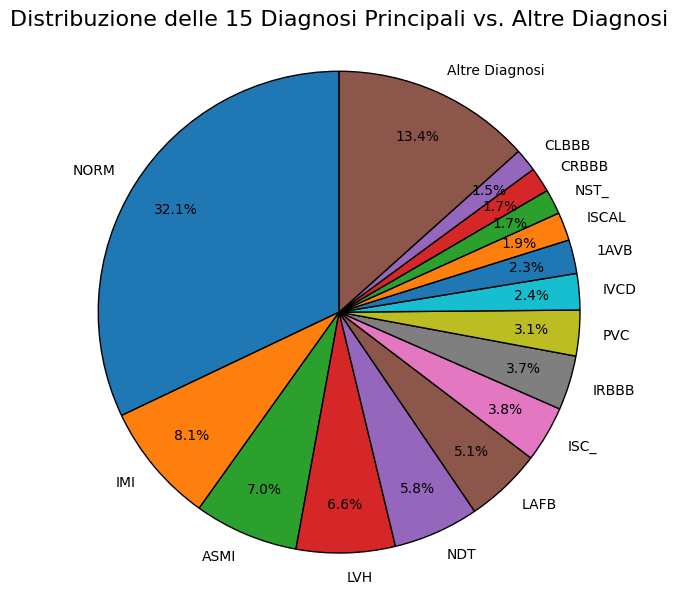

In [12]:
import pandas as pd
from collections import Counter
import ast
import matplotlib.pyplot as plt
import seaborn as sns # Mantenuto per coerenza, ma non strettamente necessario per il pie chart

# Supponiamo che il tuo DataFrame 'df' sia già caricato e pulito.
# --- PASSO 0: Conversione della colonna (Necessaria se i dizionari sono stringhe) ---
try:
    df['scp_codes'] = df['scp_codes'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
except Exception as e:
    print(f"Errore nella conversione del dizionario: {e}")
    # Gestisci l'errore

# --- PASSO 1: Estrarre e contare le diagnosi (> 0%) ---

tutte_le_diagnosi = (
    df['scp_codes']
    .apply(lambda d: [k for k, v in d.items() if v > 0] if isinstance(d, dict) else [])
    .explode()  
    .dropna()  
    .tolist()
)

conteggio_diagnosi = Counter(tutte_le_diagnosi)

# Converti in DataFrame e ordina
df_conteggi = pd.Series(conteggio_diagnosi).reset_index()
df_conteggi.columns = ['Diagnosi', 'Conteggio']
df_conteggi = df_conteggi.sort_values(by='Conteggio', ascending=False)


# --- PASSO 2: Raggruppamento (Top 7 + Altre) ---

# Definisci il numero di categorie principali
NUM_TOP = 15

# Seleziona le top N
df_top_n = df_conteggi.head(NUM_TOP)

# Calcola la somma dei conteggi per tutte le altre diagnosi
conteggio_altre = df_conteggi.iloc[NUM_TOP:]['Conteggio'].sum()

# Crea la riga per "Altre Diagnosi"
df_altre = pd.DataFrame([['Altre Diagnosi', conteggio_altre]], columns=['Diagnosi', 'Conteggio'])

# Combina le top N con la categoria "Altre Diagnosi"
df_finale_torta = pd.concat([df_top_n, df_altre])


# --- PASSO 3: Generazione del Grafico a Torta ---

# Imposta le etichette e i valori per il grafico a torta
labels = df_finale_torta['Diagnosi']
sizes = df_finale_torta['Conteggio']

# Crea la figura
plt.figure(figsize=(6,6))

# Genera il grafico a torta
plt.pie(
    sizes,
    labels=labels,
    # Imposta il formato di visualizzazione delle percentuali. %.1f%% mostra una cifra decimale.
    autopct='%1.1f%%', 
    startangle=90, # Inizia a disegnare la prima fetta dall'alto
    wedgeprops={'edgecolor': 'black'}, # Aggiunge un bordo nero tra le fette
    pctdistance=0.8 # Sposta la percentuale all'interno
)

# Assicura che il grafico sia un cerchio
plt.axis('equal') 

plt.title(f'Distribuzione delle {NUM_TOP} Diagnosi Principali vs. Altre Diagnosi', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

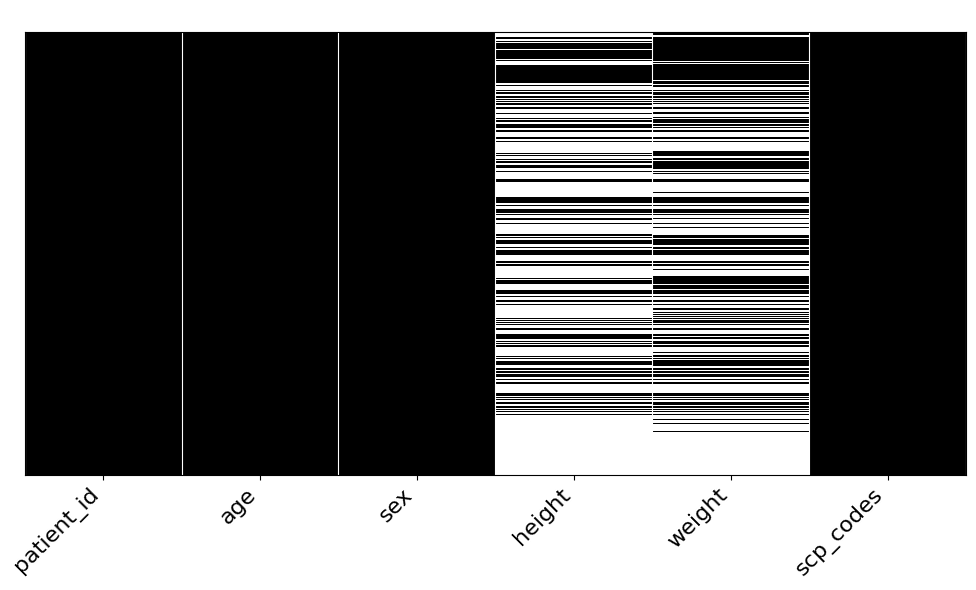

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Carica il dataset
df = pd.read_csv("db_scp_expanded.csv")

# Subset con le colonne di interesse
subset = df[['patient_id', 'age', 'sex', 'height', 'weight', 'scp_codes']]

# Crea la matrice booleana dei valori presenti (1 = valore, 0 = NaN)
mask = (~subset.isnull()).astype(int).to_numpy()

# Imposta la figura
fig, ax = plt.subplots(figsize=(10, 6))

# Mostra i dati come immagine
ax.imshow(mask, aspect='auto', interpolation='nearest', cmap='Greys')

# Imposta le etichette
ax.set_xticks(np.arange(len(subset.columns)))
ax.set_xticklabels(subset.columns, rotation=45, ha='right', fontsize=16)
ax.set_yticks([])  # nasconde le etichette delle righe per chiarezza

ax.set_title(" ", fontsize=13)
#ax.set_xlabel("Columns")
#ax.set_ylabel("Rows")

# Linee verticali di separazione tra colonne
for x in np.arange(-0.5, len(subset.columns), 1):
    ax.axvline(x, color='white', linewidth=0.8)

plt.tight_layout()
plt.show()


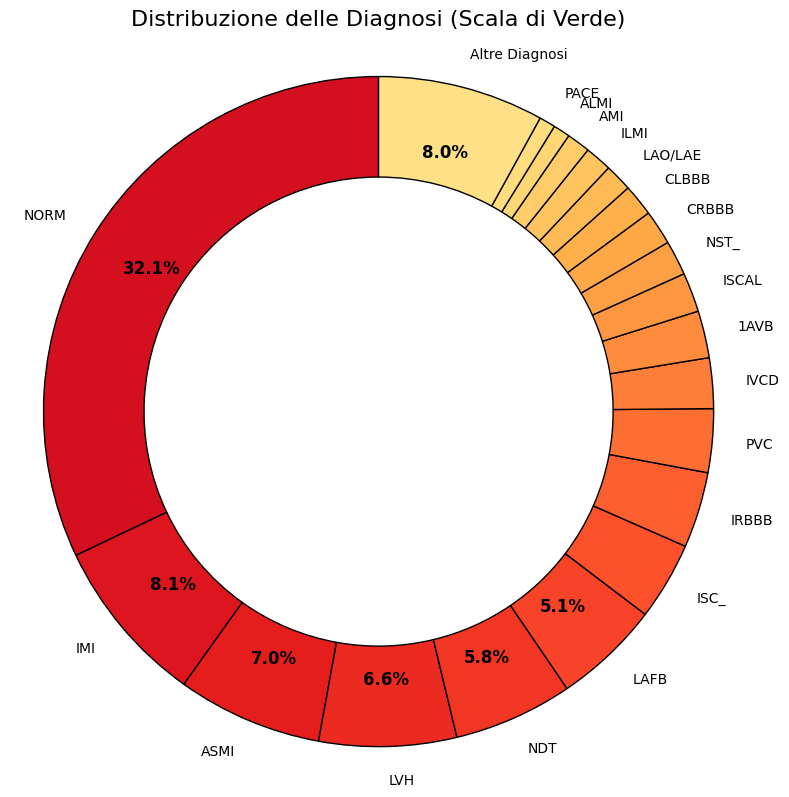

In [13]:
import pandas as pd
from collections import Counter
import ast
import matplotlib.pyplot as plt
import seaborn as sns # Mantenuto per coerenza, ma non strettamente necessario per il pie chart

# Supponiamo che il tuo DataFrame 'df' sia già caricato e pulito.
# --- PASSO 0: Conversione della colonna (Necessaria se i dizionari sono stringhe) ---
try:
    df['scp_codes'] = df['scp_codes'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
except Exception as e:
    print(f"Errore nella conversione del dizionario: {e}")
    # Gestisci l'errore

# --- PASSO 1: Estrarre e contare le diagnosi (> 0%) ---

tutte_le_diagnosi = (
    df['scp_codes']
    .apply(lambda d: [k for k, v in d.items() if v > 0] if isinstance(d, dict) else [])
    .explode()  
    .dropna()  
    .tolist()
)

conteggio_diagnosi = Counter(tutte_le_diagnosi)

# Converti in DataFrame e ordina
df_conteggi = pd.Series(conteggio_diagnosi).reset_index()
df_conteggi.columns = ['Diagnosi', 'Conteggio']
df_conteggi = df_conteggi.sort_values(by='Conteggio', ascending=False)


# --- PASSO 2: Raggruppamento (Top 7 + Altre) ---

# Definisci il numero di categorie principali
NUM_TOP = 20

# Seleziona le top N
df_top_n = df_conteggi.head(NUM_TOP)

# Calcola la somma dei conteggi per tutte le altre diagnosi
conteggio_altre = df_conteggi.iloc[NUM_TOP:]['Conteggio'].sum()

# Crea la riga per "Altre Diagnosi"
df_altre = pd.DataFrame([['Altre Diagnosi', conteggio_altre]], columns=['Diagnosi', 'Conteggio'])

# Combina le top N con la categoria "Altre Diagnosi"
df_finale_torta = pd.concat([df_top_n, df_altre])


# --- PASSO 3: Generazione del Grafico a Ciambella con Palette e Logica Percentuali Modificate ---

# Imposta le etichette e i valori per il grafico
labels = df_finale_torta['Diagnosi']
sizes = df_finale_torta['Conteggio']
totale = sizes.sum()
percentages = (sizes / totale) * 100

# 1. Definisci la NUOVA Palette di Colori (Rosso -> Giallo)
# Uso 'YlOrRd' (Yellow-Orange-Red) invertito per avere il Rosso scuro per la fetta più grande.
colors = plt.cm.YlOrRd(np.linspace(0.8, 0.2, len(sizes))) 
# np.linspace(0.8, 0.2, len(sizes)) campiona le tonalità dal rosso scuro (0.8) al giallo (0.2).

# 2. Definisci la funzione per l'autopct (mostra % solo se > 5)
def autopct_func(pct):
    """Visualizza la percentuale solo se è maggiore del 5%."""
    # Arrotonda e verifica la condizione
    return ('%1.1f%%' % pct) if pct > 5 else ''

# Crea la figura
plt.figure(figsize=(8,8))

# Genera il grafico a ciambella (pie chart con un cerchio bianco centrale)
wedges, texts, autotexts = plt.pie(
    sizes,
    labels=labels,
    autopct=autopct_func, # Usa la funzione personalizzata
    startangle=90,
    wedgeprops={'edgecolor': 'black', 'width': 0.3}, # 'width': 0.3 crea l'effetto ciambella
    colors=colors, # Usa la palette di verdi
    pctdistance=0.8, # Sposta la percentuale all'interno
    textprops={'fontsize': 10} # Dimensione del testo per le etichette (Diagnosi)
)

# Rendi il testo della percentuale leggibile e in grassetto, se presente
for autotext in autotexts:
    if autotext.get_text() != '':
        autotext.set_color('black')
        autotext.set_weight('bold')
        autotext.set_fontsize(12)

# Assicura che il grafico sia un cerchio
plt.axis('equal') 

plt.title(f'Distribuzione delle Diagnosi (Scala di Verde)', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

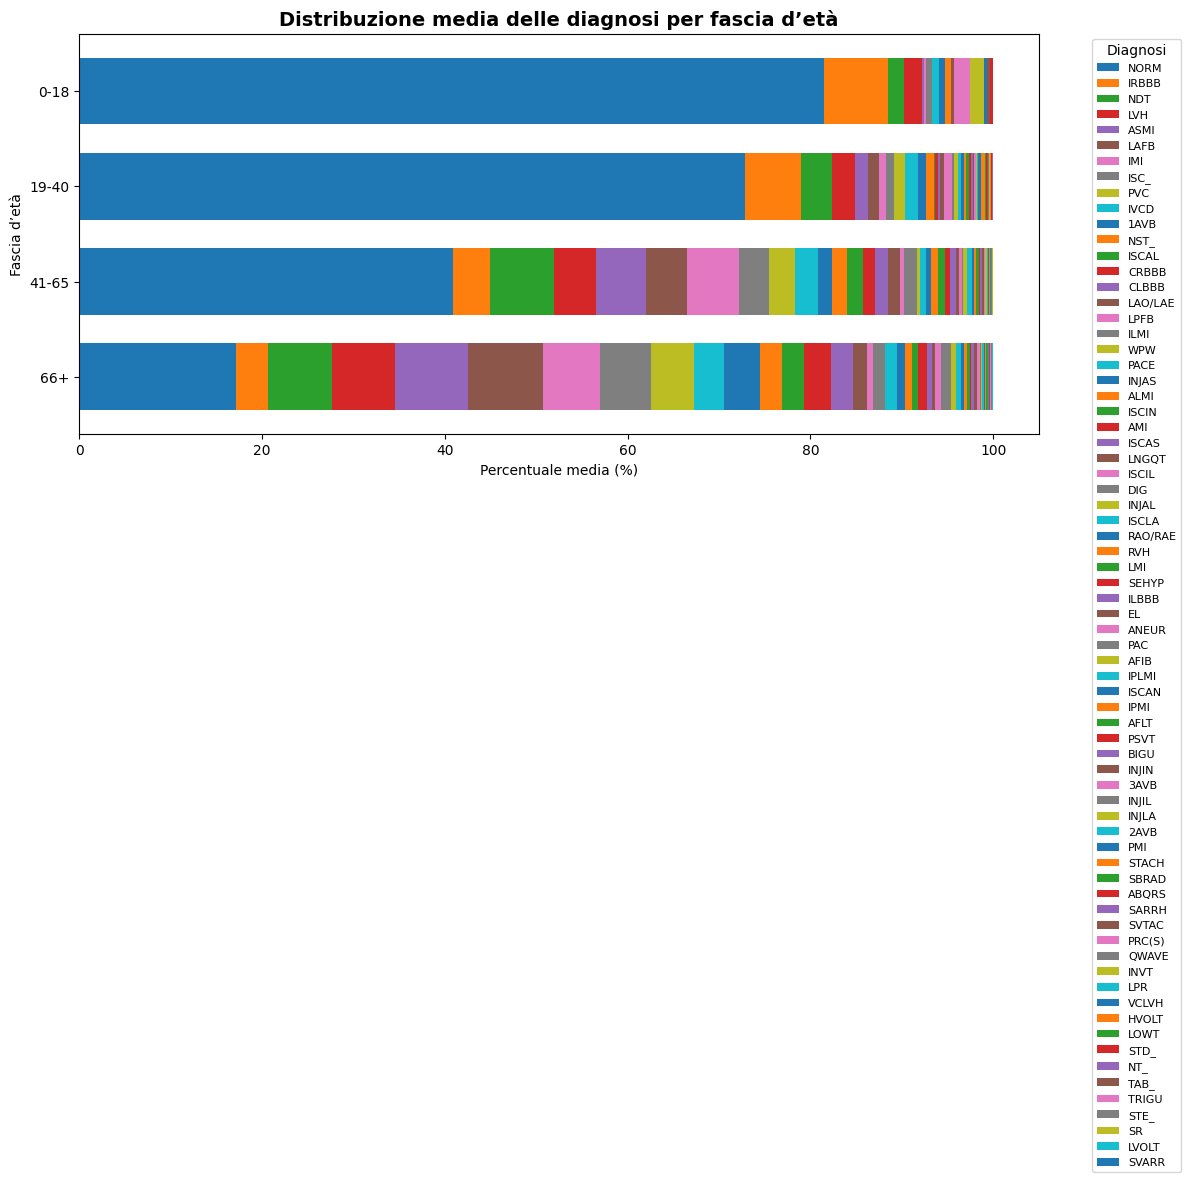

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('db_scp_expanded.csv')
diagnosi_uniche = np.array(diagnosi_df.columns)


# 1️ Creazione delle fasce d’età
df['AgeRange'] = pd.cut(df['age'],
                        bins=[0, 18, 40, 65, float('inf')],
                        labels=['0-18', '19-40', '41-65', '66+'],
                        right=True)

# 2️ Calcolo della media delle likelihood per fascia d’età
mean_probs = df.groupby('AgeRange')[diagnosi_uniche].mean()

# 3️ Normalizzazione in percentuale per ogni fascia
# In modo che ogni barra sommi a 100%
mean_probs_norm = mean_probs.div(mean_probs.sum(axis=1), axis=0) * 100

# 4️ Ordine delle diagnosi (colonne) in base alla media complessiva decrescente
order = mean_probs_norm.mean(axis=0).sort_values(ascending=False).index
mean_probs_sorted = mean_probs_norm[order]

# 5️ Inverti l’ordine delle fasce (così la più giovane è in alto)
mean_probs_sorted = mean_probs_sorted.iloc[::-1]

# 6 Grafico orizzontale (barh)
plt.figure(figsize=(12, 9))
mean_probs_sorted.plot(kind='barh', stacked=True, ax=plt.gca(), width=0.7)

plt.title('Distribuzione media delle diagnosi per fascia d’età', fontsize=14, weight='bold')
plt.xlabel('Percentuale media (%)')
plt.ylabel('Fascia d’età')
plt.legend(title='Diagnosi', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()

File 'db_scp_expanded.csv' caricato con successo.
/tmp/ipykernel_644/3260329624.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_probs = df.groupby('AgeRange')[diagnosi_uniche].mean()


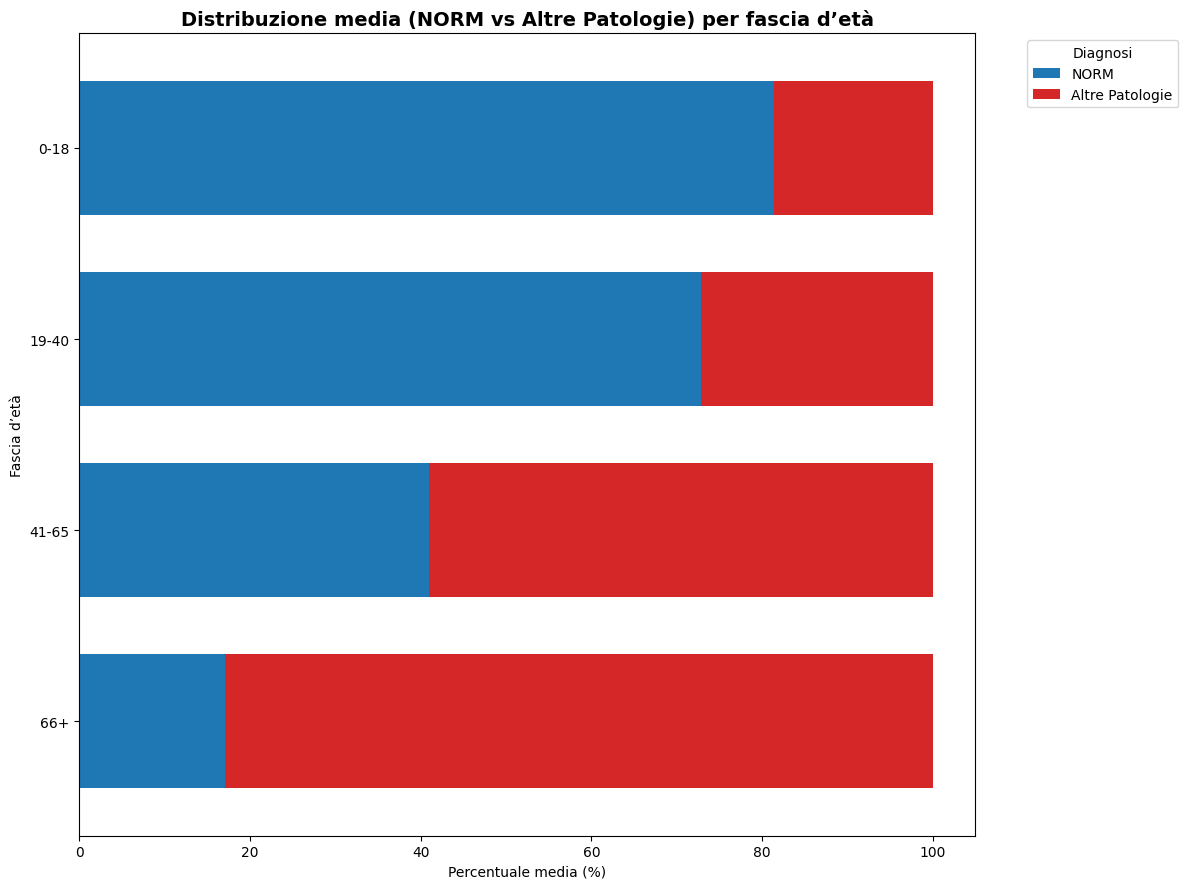

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- 0. Caricamento e Definizione Colonne ---
try:
    df = pd.read_csv('db_scp_expanded.csv')
    print("File 'db_scp_expanded.csv' caricato con successo.")
except FileNotFoundError:
    print("ERRORE: File 'db_scp_expanded.csv' non trovato.")
    exit()

# Identifichiamo le colonne delle diagnosi
colonne_da_escludere = ['patient_id', 'age', 'sex', 'weight', 'height', 'scp_codes']
diagnosi_uniche = [col for col in df.columns if col not in colonne_da_escludere]

if 'NORM' not in diagnosi_uniche:
    print("ATTENZIONE: Colonna 'NORM' non trovata. Il grafico potrebbe essere errato.")
    if 'NORM' in df.columns:
        diagnosi_uniche.append('NORM')

# --- 1️ Creazione delle fasce d’età ---
df['AgeRange'] = pd.cut(df['age'],
                        bins=[0, 18, 40, 65, float('inf')],
                        labels=['0-18', '19-40', '41-65', '66+'],
                        right=True)

# --- 2️ Calcolo della media delle likelihood per fascia d’età ---
mean_probs = df.groupby('AgeRange')[diagnosi_uniche].mean()

# --- 3️ Raggruppamento in "NORM" e "Altre Patologie" ---
altre_colonne = [col for col in diagnosi_uniche if col != 'NORM']

df_summary = pd.DataFrame()
df_summary['NORM'] = mean_probs['NORM']
df_summary['Altre Patologie'] = mean_probs[altre_colonne].sum(axis=1)

# --- 4️ Normalizzazione in percentuale ---
mean_probs_norm = df_summary.div(df_summary.sum(axis=1), axis=0) * 100


order = ['NORM', 'Altre Patologie']
mean_probs_sorted = mean_probs_norm[order]

# Definiamo i colori specifici
colors = {
    'NORM': '#1f77b4',          # Blu come nel grafico originale della collega
    'Altre Patologie': '#d62728' # Rosso per tutte le altre patologie
}

# 6️ Inverti l’ordine delle fasce (così la più giovane è in alto)
mean_probs_sorted = mean_probs_sorted.iloc[::-1]

# --- 7️ Grafico orizzontale (barh) ---
plt.figure(figsize=(12, 9))

# Passiamo il dizionario dei colori direttamente
mean_probs_sorted.plot(kind='barh', 
                       stacked=True, 
                       ax=plt.gca(), 
                       width=0.7, 
                       color=[colors[col] for col in order]) # Qui usiamo i colori definiti

plt.title('Distribuzione media (NORM vs Altre Patologie) per fascia d’età', fontsize=14, weight='bold')
plt.xlabel('Percentuale media (%)')
plt.ylabel('Fascia d’età')
# La legenda mostrerà solo "NORM" e "Altre Patologie" con i colori corrispondenti
plt.legend(title='Diagnosi', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

In [46]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

# --- 1. Caricamento Dati ---
try:
    df = pd.read_csv('db_scp_expanded.csv')
    print("File 'db_scp_expanded.csv' caricato con successo.")
except FileNotFoundError:
    print("ERRORE: File 'db_scp_expanded.csv' non trovato.")
    exit()

# Controlliamo se 'NORM' esiste
if 'NORM' not in df.columns:
    print("ERRORE: La colonna 'NORM' è necessaria per questo test.")
    exit()

# --- 2. Creazione delle Categorie per il Test ---

# 2a. Creazione Fasce d'Età
df['AgeRange'] = pd.cut(df['age'],
                        bins=[0, 18, 40, 65, float('inf')],
                        labels=['0-18', '19-40', '41-65', '66+'],
                        right=True)

# 2b. Creazione Gruppo Diagnosi (Logica Semplificata)
# Esattamente come richiesto: NORM vs Altre
df['GruppoDiagnosi'] = np.where(df['NORM'] > 0, 
                               'NORM', 
                               'Altre Patologie')

print("Categorie 'AgeRange' e 'GruppoDiagnosi' create.")

# --- 3. Costruzione della Tabella di Contingenza (CONTEGGI) ---
# Contiamo quanti pazienti rientrano in ogni incrocio

contingency_table = pd.crosstab(df['AgeRange'], df['GruppoDiagnosi'])

print("\n============================================")
print("--- Tabella di Contingenza (Conteggi Osservati) ---")
print(contingency_table)
print("============================================")

# --- 4. Esecuzione del Test del Chi-Quadro ---
try:
    chi2, p_value, dof, expected_freq = chi2_contingency(contingency_table)

    print("\n--- Risultati del Test Chi-Quadro ---")
    print(f"Statistica Chi-Quadro (χ²): {chi2:.4f}")
    print(f"Gradi di Libertà (dof): {dof}")
    print(f"P-Value: {p_value:.6f}")

    print("\n--- Interpretazione ---")
    if p_value < 0.05:
        print(f"RISULTATO: Significativo (p < 0.05)")
        print("C'è un'associazione statisticamente significativa tra la fascia d'età e il tipo di diagnosi (NORM vs. Altre).")
        print("Il trend che vedi nel grafico è molto probabilmente reale.")
    else:
        print(f"RISULTATO: Non Significativo (p >= 0.05)")
        print("Non c'è un'associazione statisticamente significativa tra la fascia d'età e il tipo di diagnosi.")
        print("Le differenze viste nel grafico potrebbero essere dovute al caso.")

except ValueError as e:
    print(f"\nERRORE: Impossibile eseguire il test del Chi-Quadro.")
    print(f"Dettagli: {e}")

File 'db_scp_expanded.csv' caricato con successo.
Categorie 'AgeRange' e 'GruppoDiagnosi' create.

--- Tabella di Contingenza (Conteggi Osservati) ---
GruppoDiagnosi  Altre Patologie  NORM
AgeRange                             
0-18                         35   250
19-40                       489  2038
41-65                      4101  4358
66+                        5541  2057

--- Risultati del Test Chi-Quadro ---
Statistica Chi-Quadro (χ²): 2619.3798
Gradi di Libertà (dof): 3
P-Value: 0.000000

--- Interpretazione ---
RISULTATO: Significativo (p < 0.05)
C'è un'associazione statisticamente significativa tra la fascia d'età e il tipo di diagnosi (NORM vs. Altre).
Il trend che vedi nel grafico è molto probabilmente reale.


La **Statistica Chi-Quadro ($\chi^2$)** è il numero che misura *quanto* i tuoi dati osservati sono diversi da quelli che ti aspetteresti se non ci fosse alcun legame tra le variabili.

Puoi pensarla come un **"punteggio di discrepanza"**.

* **$\chi^2$ vicino a 0:** Significa che i tuoi dati osservati (i conteggi nella tabella) sono *molto simili* a quelli che ti aspetteresti per puro caso. Non c'è legame.
* **$\chi^2$ grande:** Significa che i tuoi dati osservati sono *molto diversi* da quelli attesi. La discrepanza è grande, suggerendo che qualcosa (non il caso) sta causando questa differenza.

### 🎯 Nel Tuo Caso Specifico

Il tuo risultato è **$\chi^2 = 2619.3798$**.

Questo è un numero **enormemente grande**.

Significa che la differenza tra i conteggi di pazienti che hai *osservato* nella tua tabella e i conteggi che ti saresti *aspettato* se l'età e la diagnosi fossero totalmente indipendenti è massiccia.

È proprio questo "punteggio di discrepanza" altissimo (2619) che viene poi convertito nel **P-Value di 0.000000**, il quale ti dice che è statisticamente impossibile che una discrepanza così grande sia avvenuta per caso.

## Prima di imputare

- Visualizzare quanti dati di altezza e peso mancano (torta)

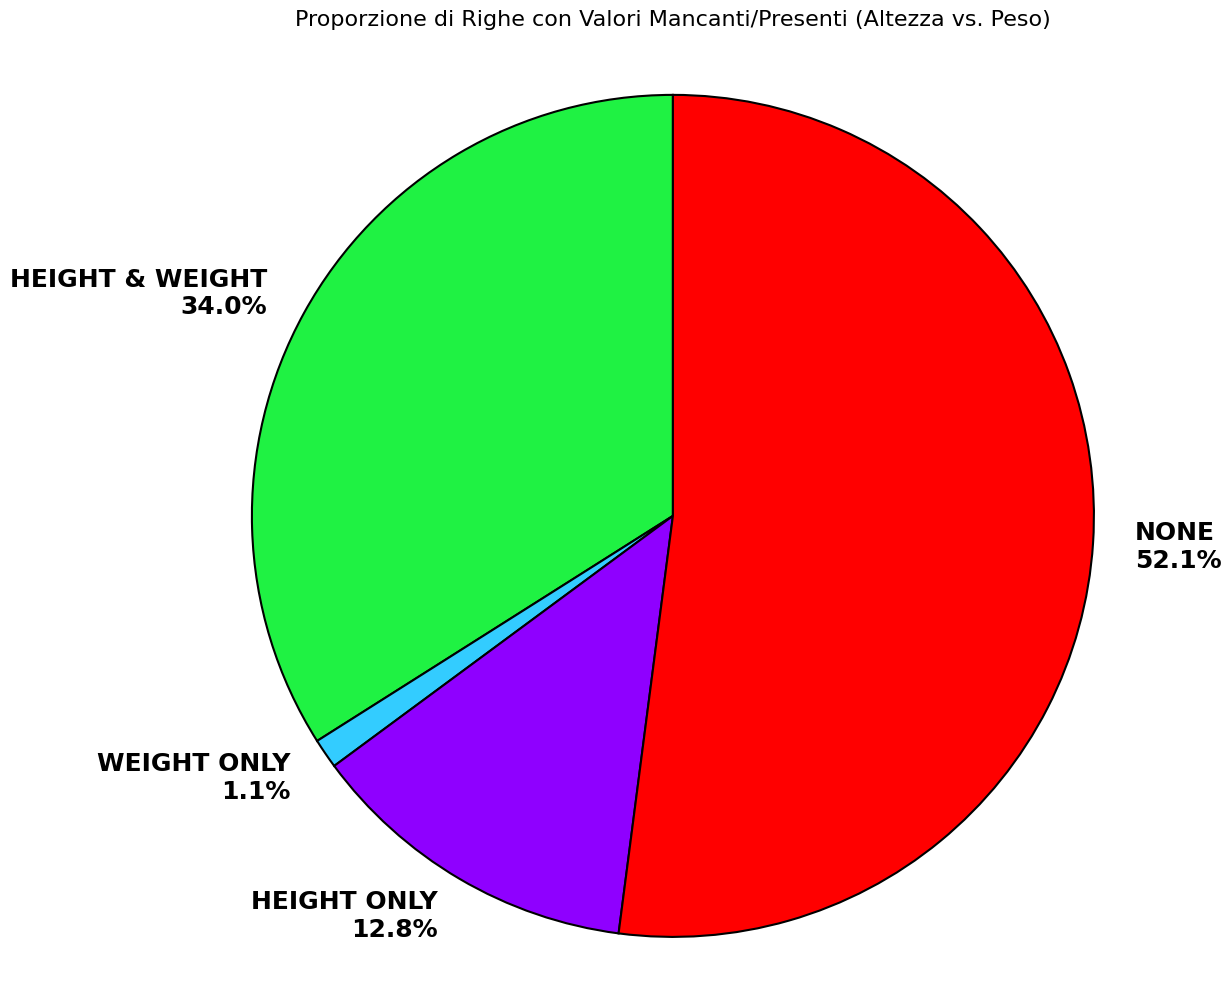

In [15]:
# --- INIZIO LOGICA: Analisi e Conteggio dei Valori ---

'''
# 1. Crea maschere booleane per la presenza dei dati (valori NON nulli)
has_height = df['height'].notna()
has_weight = df['weight'].notna()

# 2. Calcola i conteggi per le quattro categorie
count_both = (has_height & has_weight).sum()
count_only_weight = (~has_height & has_weight).sum()
count_only_height = (has_height & ~has_weight).sum()
count_neither = (~has_height & ~has_weight).sum()

'''

solo_peso_mancante_df = df[df['weight'].isnull() & df['height'].notnull()]
count_only_weight = len(solo_peso_mancante_df)

# --- CASO 2: Manca solo 'height' ---
solo_altezza_mancante_df = df[df['height'].isnull() & df['weight'].notnull()]
count_only_height = len(solo_altezza_mancante_df)

# --- CASO 3: Mancano entrambi ---
entrambi_mancanti_df = df[df['weight'].isnull() & df['height'].isnull()]
count_neither = len(entrambi_mancanti_df) # Nome corretto

# --- CASO 4: Completi (non mancano nessuno dei due) ---
completi_df = df[df['weight'].notnull() & df['height'].notnull()]
count_both = len(completi_df)


# 3. Prepara i dati per il grafico a torta
counts = [count_both, count_only_weight, count_only_height, count_neither]
raw_labels = [
    'HEIGHT & WEIGHT', 
    'WEIGHT ONLY', 
    'HEIGHT ONLY', 
    'NONE'
]
total_rows = sum(counts)

# 4. Definisci i colori richiesti
custom_colors = [
    '#1ff243',     # Entrambi (Verde brillante)
    '#33ccff',     # Solo Peso (Azzurro cielo)
    '#8f00ff',     # Solo Altezza (Giallo puro)
    '#ff0000'      # Nessuno (Rosso puro)
]

# --- MODIFICA CHIAVE: Calcolo delle Percentuali e Aggiornamento delle Labels ---

if total_rows > 0:
    # Calcola le percentuali
    percentages = (np.array(counts) / total_rows) * 100
    
    # Concatena le percentuali e i conteggi alle etichette
    labels = []
    for i in range(len(raw_labels)):
        pct = percentages[i]
        count = counts[i]
        # Formato: "Nome Categoria (X.X% - N=XXX)"
        new_label = f"{raw_labels[i]}\n{pct:.1f}%"
        labels.append(new_label)

    # --- PASSO 4: Generazione del Grafico a Torta ---
    
    plt.figure(figsize=(12, 10)) # Aumentata la dimensione per contenere le etichette lunghe

    # Genera il grafico a torta
    # NOTA: L'argomento 'autopct' è stato rimosso!
    plt.pie(
        counts,
        labels=labels, # Usa le nuove labels concatenate
        startangle=90, 
        wedgeprops={'edgecolor': 'black', 'linewidth': 1.5},
        colors=custom_colors,
        textprops={'fontsize': 18, 'color': 'black', 'weight': 'bold'} # Diminuita la dimensione del testo per evitare sovrapposizioni
    )

    plt.title('Proporzione di Righe con Valori Mancanti/Presenti (Altezza vs. Peso)', fontsize=16, pad=20)
    plt.axis('equal') # Assicura che il grafico sia un cerchio
    plt.tight_layout()
    plt.show()
else:
    print("Errore: Il DataFrame non contiene righe per l'analisi.")

## Weight Distribution

- Distribuzione del peso (dove c’è)

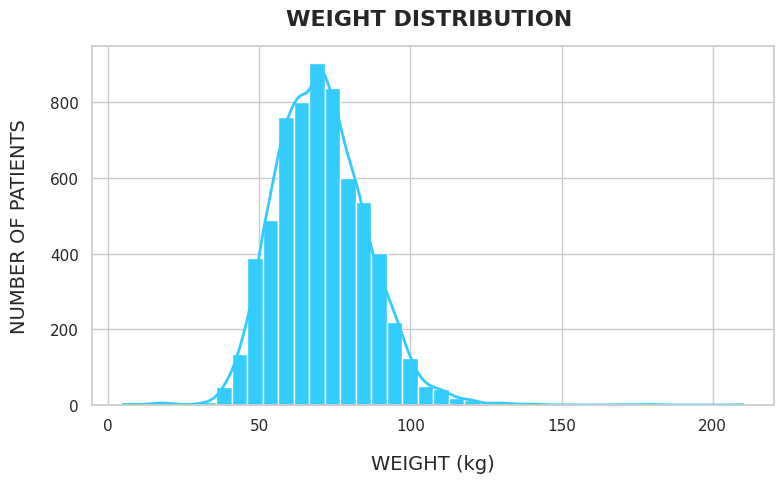

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# import numpy as np <-- Rimosso, non più necessario

df = pd.read_csv('db_scp_expanded.csv')

# (Si assume che 'df' sia già stato caricato prima di questo blocco)

# --- Filtra i dati ---
solo_peso = df[df['weight'].notnull() & df['height'].notnull()]

# --- Blocco di calcolo bin rimosso ---
# (Tutto il codice da min_peso a NUM_BINS_10KG è stato eliminato)
# ---------------------------------------------------

sns.set_theme(style="whitegrid")

plt.figure(figsize=(8,5))
sns.histplot(
    data=solo_peso, 
    x="weight", 
    bins=40,  # <-- MODIFICATO: Impostato a 40
    color="#33ccff",
    kde=True, 
    line_kws={'color': 'black', 'linewidth': 2},
    alpha = 1
)

# <-- MODIFICATO: Titolo aggiornato per riflettere i 40 bin
plt.title("WEIGHT DISTRIBUTION ", fontsize=16, fontweight='bold', pad=15) 
plt.xlabel('WEIGHT (kg)', fontsize=14, labelpad=15)
plt.ylabel('NUMBER OF PATIENTS', fontsize=14, labelpad=15)
plt.tight_layout()
plt.show()

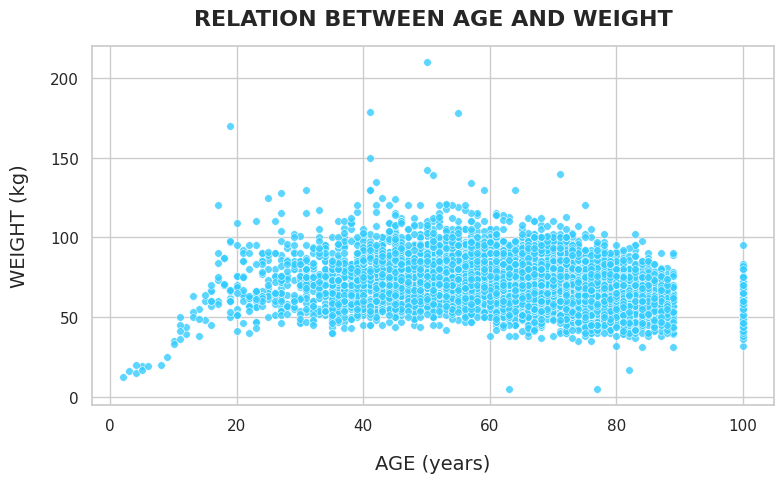

In [53]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(8,5))
sns.scatterplot(data=solo_peso, x="age", y="weight", color="#33ccff", alpha=0.8, s=30)

plt.title("RELATION BETWEEN AGE AND WEIGHT", fontsize=16, fontweight='bold', pad=15)
plt.xlabel("AGE (years)", fontsize=14, labelpad=15)
plt.ylabel("WEIGHT (kg)", fontsize=14, labelpad=15)
plt.tight_layout()
plt.show()

## Height Distribution

- Distribuzione dell’altezza (dove c’è)

I valori di altezza variano da un minimo di 85.0 cm a un massimo di 209.0 cm.


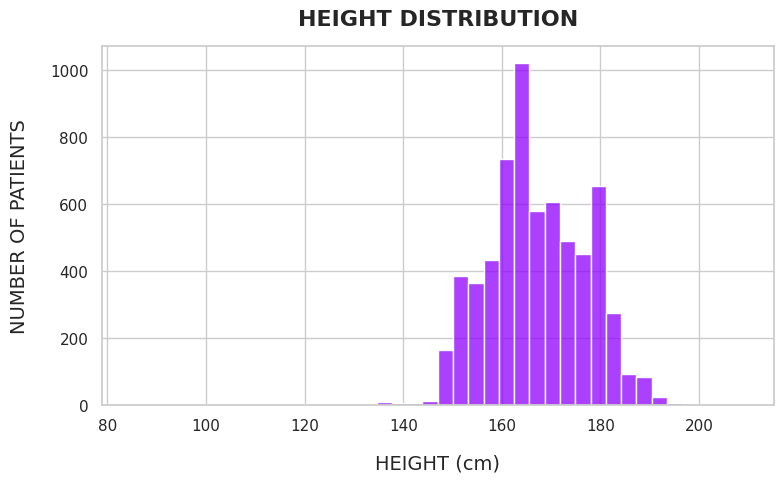

In [56]:
solo_altezza = df[df['height'].notnull() & df['weight'].notnull()]

min_altezza = solo_altezza['height'].min()
max_altezza = solo_altezza['height'].max()
print(f"I valori di altezza variano da un minimo di {min_altezza} cm a un massimo di {max_altezza} cm.")

sns.set_theme(style="whitegrid")

plt.figure(figsize=(8,5))
sns.histplot(data=solo_altezza, x="height", bins=40, color="#8f00ff")

plt.title("HEIGHT DISTRIBUTION", fontsize=16, fontweight='bold', pad=15)
plt.xlabel('HEIGHT (cm)', fontsize=14, labelpad=15)   # aumenta distanza dalla x
plt.ylabel('NUMBER OF PATIENTS', fontsize=14, labelpad=15)  # aumenta distanza dalla y
plt.tight_layout()
plt.show()

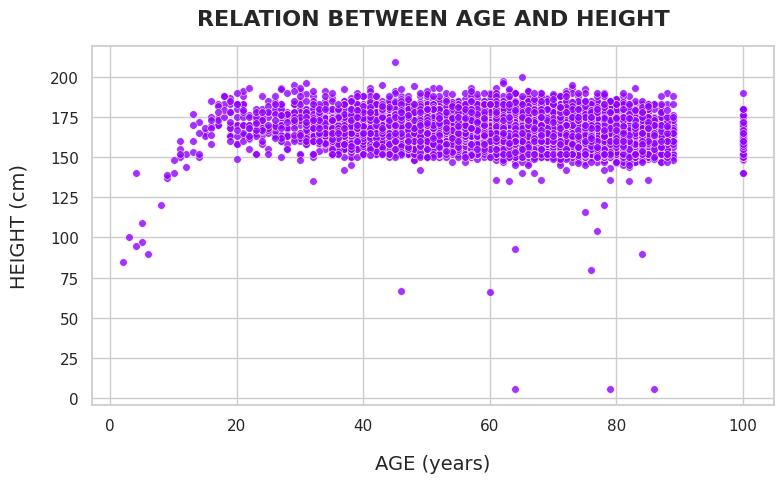

In [19]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(8,5))
sns.scatterplot(data=solo_altezza, x="age", y="height", color="#8f00ff", alpha=0.8, s=30)

plt.title("RELATION BETWEEN AGE AND HEIGHT", fontsize=16, fontweight='bold', pad=15)
plt.xlabel("AGE (years)", fontsize=14, labelpad=15)
plt.ylabel("HEIGHT (cm)", fontsize=14, labelpad=15)
plt.tight_layout()
plt.show()

- Plot peso (asse x) e altezza (asse y) (dove c’è)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


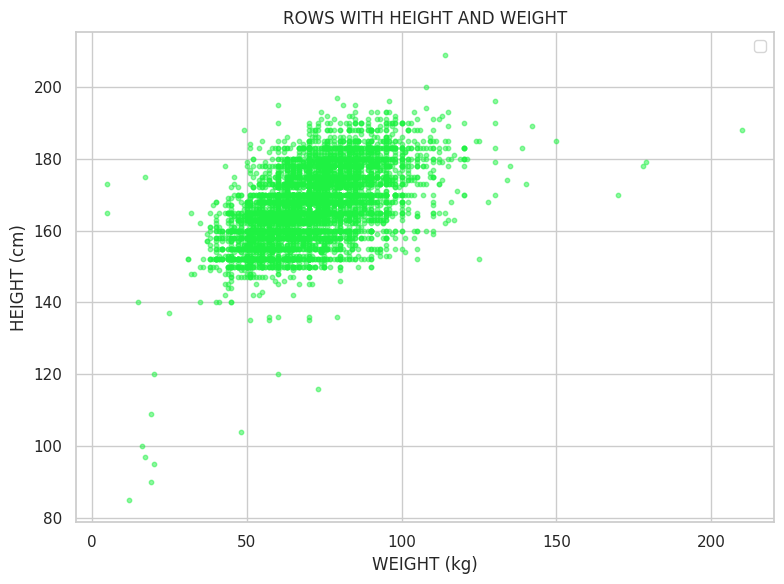

In [20]:
df_completi = df[df['height'].notnull() & df['weight'].notnull()]

plt.figure(figsize=(8,6))

# Dati originali (blu)
plt.scatter(df_completi["weight"], df_completi["height"], 
            color="#1ff243", alpha=0.5, s=10)


# Migliora l’estetica
plt.xlabel("WEIGHT (kg)")
plt.ylabel("HEIGHT (cm)")
plt.title("ROWS WITH HEIGHT AND WEIGHT")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Mostra il grafico
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=247b8f4a-5d0c-407e-bcc1-03b5acbab0dd' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>